In [1]:
from transform_ps.etl.data_type import DataFactory
from transform_ps.etl.util import clear_cwd_cache

In [2]:
# clear_cwd_cache()

### Global Vars

In [3]:
SINGLE_GOAL = 2754275
TICKETMASTER_REV = 178420.5
TICKETMASTER_TIX = 4703
MOS_QTR = 2
FY = 20

### Create Data Types and Get Data

In [4]:
factory = DataFactory()

In [5]:
mos = factory.create_data_type('mode_of_sale')
tix = factory.create_data_type('ticket')

In [6]:
mos.get_data(fys=FY, qtr=MOS_QTR)

reading from cache
Finished prepare_data in 0.0096 secs


In [7]:
tix.get_data(fys=[FY-3, FY-2, FY-1, FY])

reading from cache
Finished prepare_data in 2.1166 secs


### Prep

#### MoS

In [8]:
mos_data = mos.working.loc[mos.working['season'].isin([
    'Classics', 'Pops', 'Summer', 'Specials', 'Family'
])].reset_index(drop=True)

#### tix

In [9]:
tix_data = tix.type.transform['price_type_group'](tix.working)
tix_data = tix.type.filters['paid'](tix_data, 'paid_amt')

#### Fulfilled Funnel

In [10]:
three_concert_data = tix.type.filters['fys'](tix_data, [FY-1, FY])
three_concert_data = tix.type.filters['series'](three_concert_data, ['Classics', 'Pops', 'Summer'])
three_concert_data = tix.type.filters['non_subs'](three_concert_data)
three_concert_min = tix.type.filters['min_transactions'](three_concert_data, 'summary_cust_id', 'perf_dt', 3)

### Current FY Single Sales

In [11]:
current_tix = tix.type.filters['fys'](tix_data, [FY])
current_tix = tix.type.filters['single_sales'](current_tix)

In [12]:
revenue_td, tix_sold_td = current_tix.aggregate({'paid_amt': ['sum', 'count']}).paid_amt
households_td = len(set(current_tix.summary_cust_id))

### New To File and Retained New to File

In [13]:
single_and_main = tix.type.filters['non_subs'](tix.working)
single_and_main = tix.type.filters['series'](single_and_main, ['Classics', 'Pops', 'Summer'])

In [14]:
new_to_file, retained_new = tix.type.filters['ntf'](single_and_main)

## KPIs

In [15]:
kpis = {
        '%_to_goal': round((revenue_td + TICKETMASTER_REV) / SINGLE_GOAL * 100, 1),
        'tickets sold': tix_sold_td + TICKETMASTER_TIX,
        'households': households_td,
        'new_to_file': len(new_to_file),
        'retained_new_to_file': len(retained_new),
        'three_concerts_current_and_py': len(three_concert_min)
    }

In [16]:
kpis

{'%_to_goal': 46.1,
 'tickets sold': 24164.0,
 'households': 5339,
 'new_to_file': 2373,
 'retained_new_to_file': 158,
 'three_concerts_current_and_py': 580}

## Plots

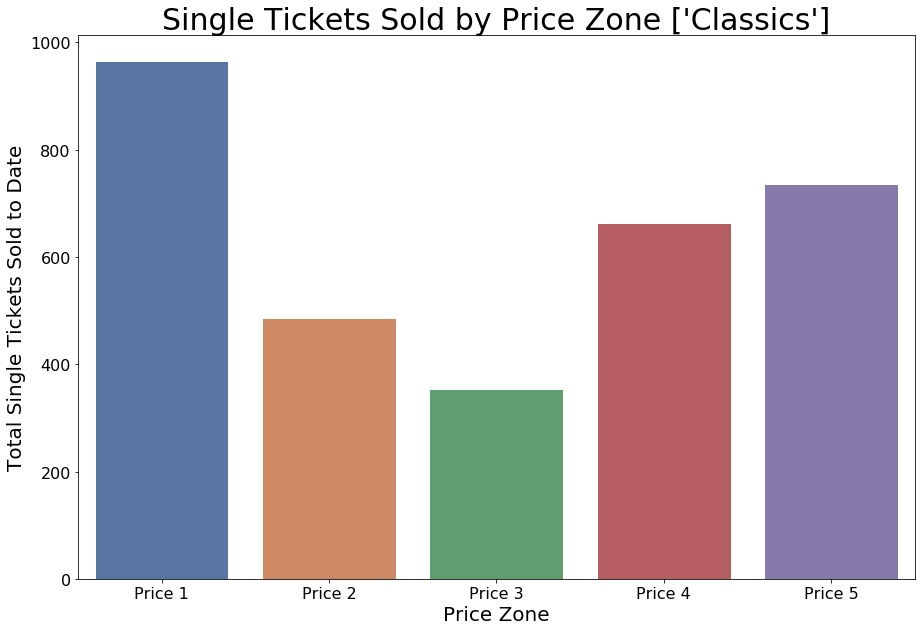

In [17]:
tix.type.ticket_plots.plot_singles_by_zone(data=tix.working, series=['Classics'], fys=[FY])

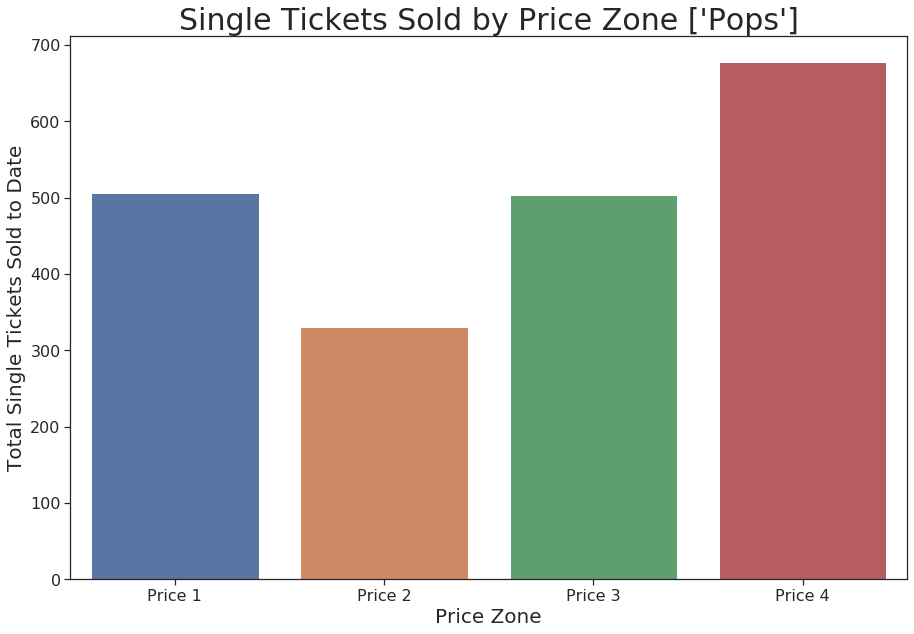

In [18]:
tix.type.ticket_plots.plot_singles_by_zone(data=tix.working, series=['Pops'], fys=[FY])

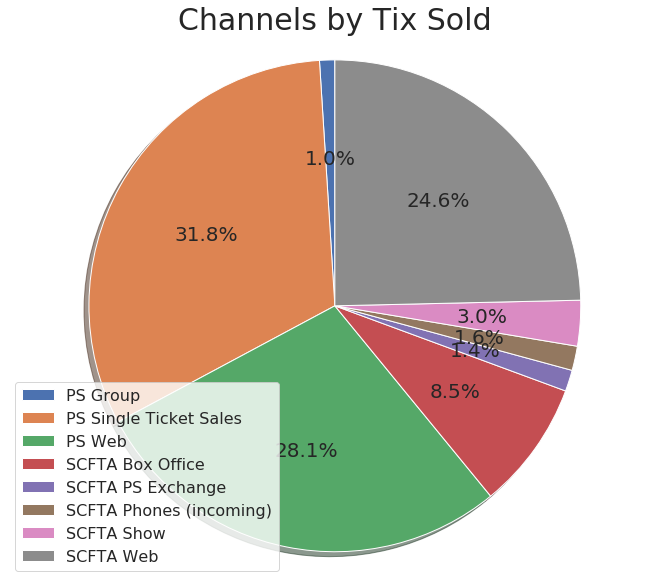

In [21]:
mos.type.mos_plots.pie_plot(mos_data, category='ordered')